In [1]:
!git clone https://github.com/SrijanDas/Face-Mask-Detection.git

Cloning into 'Face-Mask-Detection'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 1428 (delta 1), reused 5 (delta 0), pack-reused 1419
Receiving objects: 100% (1428/1428), 69.96 MiB | 36.95 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [2]:
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
import cv2

from keras.models import Sequential
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from keras.callbacks import ReduceLROnPlateau
from sklearn.utils import shuffle

from sklearn.metrics import confusion_matrix, f1_score
import numpy as np
import os

## Loading the data

In [3]:
labels = ['with_mask', 'without_mask']
img_size = 150

def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        label_num = labels.index(label)
        
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_img_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_img_arr, label_num])
            except Exception as e:
                print(e)
    return data

In [4]:
train = get_training_data('./Face-Mask-Detection/train')
test = get_training_data('./Face-Mask-Detection/test')

## Data Visualization

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


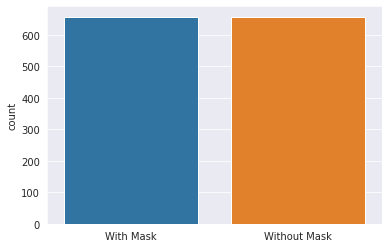

In [6]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("With Mask")
    else:
        l.append("Without Mask")
sns.set_style('darkgrid')
sns.countplot(l)

Text(0.5, 1.0, 'with_mask')

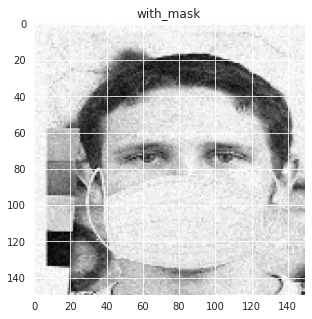

In [7]:
plt.figure(figsize=(5, 5))
plt.imshow(train[1][0], cmap='gray')
plt.title(labels[train[1][1]])

Text(0.5, 1.0, 'without_mask')

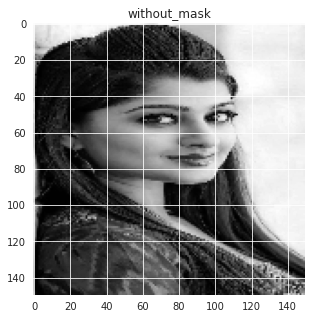

In [8]:
plt.figure(figsize=(5, 5))
plt.imshow(train[-2][0], cmap='gray')
plt.title(labels[train[-2][1]])

## Training the model

In [9]:
def get_feature_and_label(data):
  x, y = [], []
  for feature, label in data:
    x.append(feature)
    y.append(label)
  return x, y

In [10]:
x_train, y_train = get_feature_and_label(train)
x_test, y_test = get_feature_and_label(test)

In [11]:
print(x_train[1])
print(y_train[1])

[[239 238 254 ... 246 240 240]
 [239 243 253 ... 252 249 242]
 [248 245 250 ... 238 240 245]
 ...
 [247 242 241 ... 234 182 236]
 [232 241 253 ... 201  22  40]
 [246 250 246 ... 196  47  74]]
0


In [12]:
x_train, y_train = shuffle(x_train, y_train)
x_test, y_test = shuffle(x_test, y_test)

In [13]:
# Normalizing the data

x_train = np.array(x_train) / 255
x_test = np.array(x_test) / 255

In [14]:
#resize data for deep learning 

x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train).reshape(-1,1)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test).reshape(-1,1)


In [15]:
x_train[0]

array([[[0.93333333],
        [0.95686275],
        [0.96078431],
        ...,
        [0.97254902],
        [0.96862745],
        [0.96862745]],

       [[0.93333333],
        [0.94901961],
        [0.96078431],
        ...,
        [0.96862745],
        [0.96862745],
        [0.96862745]],

       [[0.93333333],
        [0.94901961],
        [0.95686275],
        ...,
        [0.96862745],
        [0.96078431],
        [0.96470588]],

       ...,

       [[0.93333333],
        [0.93333333],
        [0.94117647],
        ...,
        [0.9372549 ],
        [0.9372549 ],
        [0.93333333]],

       [[0.93333333],
        [0.9372549 ],
        [0.9372549 ],
        ...,
        [0.94117647],
        [0.9372549 ],
        [0.93333333]],

       [[0.9254902 ],
        [0.9372549 ],
        [0.9372549 ],
        ...,
        [0.94117647],
        [0.94117647],
        [0.93333333]]])

In [16]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [17]:

model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))

print(model.summary())

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0

In [18]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=2, verbose=1,
    factor=0.3, min_lr=0.000001)

In [19]:
model.fit(
    datagen.flow(x_train, y_train, batch_size=10),
    epochs=12,
    validation_data=datagen.flow(x_test, y_test),
    callbacks=[learning_rate_reduction]
    )

Epoch 1/12
132/132 [==============================] - 81s 604ms/step - loss: 1.0690 - accuracy: 0.7221 - val_loss: 1.3939 - val_accuracy: 0.5000
Epoch 2/12
132/132 [==============================] - 79s 596ms/step - loss: 0.2672 - accuracy: 0.9077 - val_loss: 4.4100 - val_accuracy: 0.5000
Epoch 3/12
132/132 [==============================] - 79s 595ms/step - loss: 0.1986 - accuracy: 0.9336 - val_loss: 0.8132 - val_accuracy: 0.5000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/12
132/132 [==============================] - 78s 593ms/step - loss: 0.1476 - accuracy: 0.9415 - val_loss: 0.8637 - val_accuracy: 0.5619
Epoch 5/12
132/132 [==============================] - 78s 593ms/step - loss: 0.1399 - accuracy: 0.9499 - val_loss: 0.2929 - val_accuracy: 0.8454
Epoch 6/12
132/132 [==============================] - 78s 588ms/step - loss: 0.1014 - accuracy: 0.9635 - val_loss: 0.1333 - val_accuracy: 0.9485
Epoch 7/12
132/132 [=============================

In [20]:
loss, accuracy = model.evaluate(x_test, y_test)

print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , accuracy*100 , "%")

7/7 [==============================] - 2s 308ms/step - loss: 0.0584 - accuracy: 0.9845
Loss of the model is -  0.058401018381118774
Accuracy of the model is -  98.45361113548279 %


In [29]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0], dtype=int32)

In [23]:
cm = confusion_matrix(predictions, y_test)
cm

array([[96,  2],
       [ 1, 95]])

In [24]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98        97
           1       0.99      0.98      0.98        97

    accuracy                           0.98       194
   macro avg       0.98      0.98      0.98       194
weighted avg       0.98      0.98      0.98       194



## Predictions

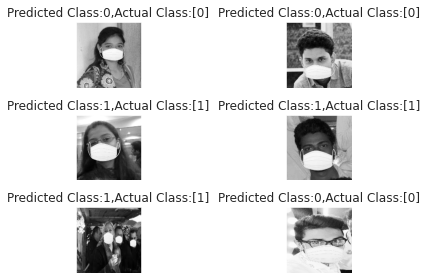

In [89]:
i = 0
for j in range(0, 6):
  plt.subplot(3,2,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(test[j][0], cmap="gray")
  plt.title(f"Predicted Class:{predictions[j]},Actual Class:{y_test[j]}")
  plt.tight_layout()
  i += 1

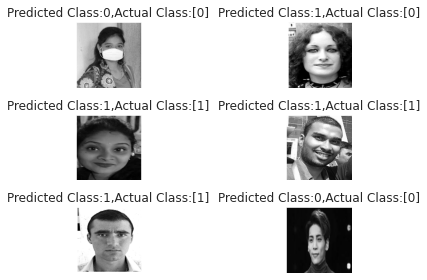

In [90]:
i = 0
for j in range(0, 6):
  plt.subplot(3,2,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(test[-j][0], cmap="gray")
  plt.title(f"Predicted Class:{predictions[-j]},Actual Class:{y_test[-j]}")
  plt.tight_layout()
  i += 1